<a href="https://colab.research.google.com/github/sanaeaba/Recommende_system_coursera/blob/master/NeuFM_Coursera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install fast-ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, BatchNormalization,concatenate,Multiply,Dot
from tensorflow.keras import regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

In [4]:
data = pd.read_csv("merged_coursera_datase.csv")
data

,Unnamed: 0,course_id,user_id,rating,Sentiment,course_difficulty
0,0,the-science-of-well-being,By Laura C,2,2,Mixed
1,1,the-science-of-well-being,By Tyson K,2,1,Mixed
2,2,the-science-of-well-being,By DULCEMARIA G S,2,0,Mixed
3,3,the-science-of-well-being,By Jonathan G,3,2,Mixed
4,4,the-science-of-well-being,By Liron S,3,2,Mixed
...,...,...,...,...,...,...
20117,20117,object-oriented-java,By Aman C 1,4,2,Beginner
20118,20118,object-oriented-java,By FPB,4,2,Beginner
20119,20119,object-oriented-java,By Alessandra G,4,0,Beginner
20120,20120,object-oriented-java,By Akash k,4,2,Beginner


In [5]:
from sklearn.preprocessing import LabelEncoder
course_encoder = LabelEncoder()
user_encoder = LabelEncoder()

data['course_id'] = course_encoder.fit_transform(data.course_id)
data['user_id'] = user_encoder.fit_transform(data.user_id)
data

,Unnamed: 0,course_id,user_id,rating,Sentiment,course_difficulty
0,0,289,8507,2,2,Mixed
1,1,289,15643,2,1,Mixed
2,2,289,3474,2,0,Mixed
3,3,289,7221,3,2,Mixed
4,4,289,8776,3,2,Mixed
...,...,...,...,...,...,...
20117,20117,210,1060,4,2,Beginner
20118,20118,210,4906,4,2,Beginner
20119,20119,210,838,4,0,Beginner
20120,20120,210,695,4,2,Beginner


In [6]:
#categorical data
categorical_cols = ['Sentiment','course_difficulty'] 
#import pandas as pd
data = pd.get_dummies(data, columns = categorical_cols)
data

,Unnamed: 0,course_id,user_id,rating,Sentiment_0,Sentiment_1,Sentiment_2,course_difficulty_Advanced,course_difficulty_Beginner,course_difficulty_Intermediate,course_difficulty_Mixed
0,0,289,8507,2,0,0,1,0,0,0,1
1,1,289,15643,2,0,1,0,0,0,0,1
2,2,289,3474,2,1,0,0,0,0,0,1
3,3,289,7221,3,0,0,1,0,0,0,1
4,4,289,8776,3,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
20117,20117,210,1060,4,0,0,1,0,1,0,0
20118,20118,210,4906,4,0,0,1,0,1,0,0
20119,20119,210,838,4,1,0,0,0,1,0,0
20120,20120,210,695,4,0,0,1,0,1,0,0


In [7]:
data['user_metadata'] = data[data.columns[4:7]].apply( lambda x: ''.join(x.dropna().astype(str)), axis=1)
data['course_metadata'] = data[data.columns[7:11]].apply( lambda x: ''.join(x.dropna().astype(str)), axis=1)
data.drop(data.iloc[:, 4:11], inplace = True, axis = 1)
data= data.drop(columns=['Unnamed: 0'])

In [8]:
data['course_metadata'] = course_encoder.fit_transform(data.course_metadata)
data['user_metadata'] = user_encoder.fit_transform(data.user_metadata)
data

,course_id,user_id,rating,user_metadata,course_metadata
0,289,8507,2,0,0
1,289,15643,2,1,0
2,289,3474,2,2,0
3,289,7221,3,0,0
4,289,8776,3,0,0
...,...,...,...,...,...
20117,210,1060,4,0,2
20118,210,4906,4,0,2
20119,210,838,4,2,2
20120,210,695,4,0,2


In [14]:
num_users = len(data.user_id.unique())
num_courses = len(data.course_id.unique())
num_course_metadata = data.course_metadata.max()
num_user_metadata = data.user_metadata.max()
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(data, target = 'rating', train_size=0.7, valid_size=0.1, test_size=0.2)

In [15]:
latent_dim = 18

# Define inputs
course_input = Input(shape=[1],name='course-input')
user_input = Input(shape=[1], name='user-input')
course_metadata_input = Input(1,name='course-metadata-input')
user_metadata_input = Input(1,name='user-metadata-input')

# MLP Embeddings
course_embedding_mlp = Embedding( num_courses + 1, latent_dim, name='course-embedding-mlp')(course_metadata_input)
course_vec_mlp = Flatten(name='flatten-course-mlp')(course_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_metadata_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
course_embedding_mf = Embedding(num_courses + 1, latent_dim, name='course-embedding-mf')(course_input)
course_vec_mf = Flatten(name='flatten-course-mf')(course_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([course_vec_mlp, user_vec_mlp])
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
#pred_mf = concatenate([course_vec_mf, user_vec_mf])
#pred_mf = Multiply()([course_vec_mf, user_vec_mf])
#pred_mf = Dot(axes=1)([course_vec_mf, user_vec_mf])
pred_mf = course_vec_mf * user_vec_mf
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, course_input,course_metadata_input, user_metadata_input], result)
#model.compile(loss='mse', optimizer='adam')
#model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='mean_absolute_error')
#model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mean_squared_error' ,metrics=['accuracy'])
#image= SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 course-metadata-input (InputLa  [(None, 1)]         0           []                               
 yer)                                                                                             
                                                                                                  
 user-metadata-input (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 course-embedding-mlp (Embeddin  (None, 1, 18)       5706        ['course-metadata-input[0][0]']  
 g)                                                                                         

In [17]:
from sklearn.metrics import mean_absolute_error
history = model.fit([X_train.user_id, X_train.course_id, X_train.course_metadata, X_train.user_metadata], y_train, epochs=65, batch_size=100, validation_data=([X_valid.user_id, X_valid.course_id, X_valid.course_metadata, X_valid.user_metadata], y_valid))
y_hat = model.predict([X_test.user_id, X_test.course_id, X_test.course_metadata, X_test.user_metadata])
y_true = y_test

Epoch 1/65
141/141 [==============================] - 2s 7ms/step - loss: 4.2343 - val_loss: 4.3673
Epoch 2/65
141/141 [==============================] - 1s 6ms/step - loss: 3.6187 - val_loss: 4.0713
Epoch 3/65
141/141 [==============================] - 1s 6ms/step - loss: 3.0304 - val_loss: 3.5179
Epoch 4/65
141/141 [==============================] - 1s 6ms/step - loss: 2.3654 - val_loss: 2.5778
Epoch 5/65
141/141 [==============================] - 1s 6ms/step - loss: 1.7122 - val_loss: 1.4368
Epoch 6/65
141/141 [==============================] - 1s 6ms/step - loss: 1.3582 - val_loss: 1.1799
Epoch 7/65
141/141 [==============================] - 1s 6ms/step - loss: 1.2240 - val_loss: 0.5891
Epoch 8/65
141/141 [==============================] - 1s 6ms/step - loss: 0.8838 - val_loss: 0.5468
Epoch 9/65
141/141 [==============================] - 1s 6ms/step - loss: 0.8273 - val_loss: 0.5223
Epoch 10/65
141/141 [==============================] - 1s 6ms/step - loss: 0.8050 - val_loss: 0.5247

In [27]:
!pip install recmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 53.2 MB/s 
     |████████████████████████████████| 793 kB 73.4 MB/s 
     |████████████████████████████████| 13.2 MB 54.4 MB/s 
     |████████████████████████████████| 1.6 MB 52.8 MB/s 
     |████████████████████████████████| 121 kB 73.8 MB/s 
     |████████████████████████████████| 965 kB 66.7 MB/s 
     |████████████████████████████████| 316 kB 72.6 MB/s 
     |████████████████████████████████| 210 kB 75.1 MB/s 
     |████████████████████████████████| 237 kB 75.1 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 140 kB 72.3 MB/s 
     |████████████████████████████████| 48 kB 6.3 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 51 kB 8.4 MB/s 
     |████████████████████████████████| 4.1 MB 57.8 MB/s 
     |███████████████████████████████

In [18]:
import recmetrics
MAE = mean_absolute_error(y_true, y_hat)
print("MAE: ", MAE)
print("MSE: ", recmetrics.mse(y_true,y_hat))
print("RMSE: ", recmetrics.rmse(y_true,y_hat))

MAE:  0.5805590280686846
MSE:  0.6879974090107118
RMSE:  0.8294560922741552


In [19]:
!pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


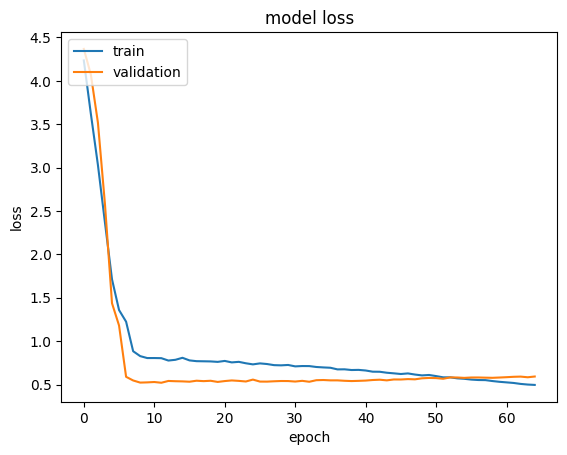

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()